# Part A - Van Gogh Painting Classifier

## Deep Learning Project - Tel Aviv University

This notebook implements a binary classifier to identify Van Gogh paintings using transfer learning with VGG19.

### Overview:
1. **Load Data**: Read pre-prepared CSV file with image paths and labels
2. **Split Dataset**: 70% train, 15% validation, 15% test
3. **Data Augmentation**: Apply transforms for training robustness
4. **Model**: VGG19 pre-trained on ImageNet, fine-tuned for binary classification
5. **Hyperparameter Tuning**: Use Optuna to find best parameters
6. **Training**: Train final model with best hyperparameters
7. **Evaluation**: Test set metrics and visualizations

### Requirements:
- Google Colab with GPU runtime
- `post_impressionism_data.csv` file (created by Get_Post_Impressionism_Data.ipynb)
- Weights & Biases account for experiment tracking

---


## 1. Environment Setup


In [1]:
# Check if running on Google Colab
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Running on Google Colab")
else:
    print("Running locally")


Running locally


In [2]:
# Install required packages: optuna (hyperparameter tuning), wandb (experiment tracking)
%pip install -q optuna wandb

Note: you may need to restart the kernel to use updated packages.


## 2. Import Libraries


In [10]:
# Import libraries
import os
import platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve
)

# Hyperparameter tuning and logging
import optuna
import wandb

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# Hardware Benchmark Setup (Required by instructions - Page 7)
print("="*60)
print("HARDWARE BENCHMARK INFORMATION")
print("="*60)
print(f"Python Version: {platform.python_version()}")
print(f"Machine Name: {platform.node()}")
print(f"GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Model: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory Total: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    print(f"GPU Memory Allocated: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")
    print(f"GPU Memory Cached: {torch.cuda.memory_reserved(0) / 1024**3:.2f} GB")
print(f"PyTorch version: {torch.__version__}")
print("="*60)


HARDWARE BENCHMARK INFORMATION
Python Version: 3.11.13
Machine Name: 52da43e540d0
GPU Available: True
GPU Model: Tesla T4
GPU Memory Total: 14.74 GB
GPU Memory Allocated: 0.02 GB
GPU Memory Cached: 0.40 GB
PyTorch version: 2.6.0+cu124


In [4]:
# Setup device (GPU/CPU) - GPU is much faster for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if device.type == 'cpu':
    print("WARNING: Running on CPU. Enable GPU in Colab: Runtime -> Change runtime type -> GPU")


Using device: cuda


In [9]:
# CPU vs GPU Benchmark (Required by instruction 1.34)
# Measure time for 20 forward+backward iterations on both CPU and GPU
import time

print("="*60)
print("CPU vs GPU BENCHMARK")
print("="*60)
print(f"Machine name: {platform.node()}")
if torch.cuda.is_available():
    print(f"GPU model: {torch.cuda.get_device_name(0)}")
print("="*60)

# Create a dummy model for benchmarking
dummy_model = nn.Sequential(
    nn.Conv2d(3, 64, 3, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.Linear(64, 2)
)
dummy_input = torch.randn(8, 3, 224, 224)
criterion = nn.CrossEntropyLoss()
dummy_labels = torch.randint(0, 2, (8,))

# CPU Benchmark
print("\nRunning CPU benchmark (20 iterations)...")
cpu_model = dummy_model.to('cpu')
cpu_input = dummy_input.to('cpu')
cpu_labels = dummy_labels.to('cpu')
cpu_optimizer = torch.optim.Adam(cpu_model.parameters(), lr=0.001)

start_time = time.time()
for _ in range(20):
    cpu_optimizer.zero_grad()
    outputs = cpu_model(cpu_input)
    loss = criterion(outputs, cpu_labels)
    loss.backward()
    cpu_optimizer.step()
cpu_time = time.time() - start_time

print(f"CPU time: {cpu_time:.4f} seconds ({cpu_time/20*1000:.2f} ms per iteration)")

# GPU Benchmark (if available)
if torch.cuda.is_available():
    # Print machine name and GPU model before results (for documentation)
    print(f"\nMachine Name: {platform.node()}")
    print(f"GPU Model: {torch.cuda.get_device_name(0)}")
    print("\nRunning GPU benchmark (20 iterations)...")
    gpu_model = dummy_model.to('cuda')
    gpu_input = dummy_input.to('cuda')
    gpu_labels = dummy_labels.to('cuda')
    gpu_optimizer = torch.optim.Adam(gpu_model.parameters(), lr=0.001)
    
    # Warmup
    for _ in range(5):
        gpu_optimizer.zero_grad()
        outputs = gpu_model(gpu_input)
        loss = criterion(outputs, gpu_labels)
        loss.backward()
        gpu_optimizer.step()
    torch.cuda.synchronize()
    
    start_time = time.time()
    for _ in range(20):
        gpu_optimizer.zero_grad()
        outputs = gpu_model(gpu_input)
        loss = criterion(outputs, gpu_labels)
        loss.backward()
        gpu_optimizer.step()
    torch.cuda.synchronize()
    gpu_time = time.time() - start_time
    
    print(f"GPU time: {gpu_time:.4f} seconds ({gpu_time/20*1000:.2f} ms per iteration)")
    print(f"\nSpeedup: {cpu_time/gpu_time:.2f}x faster on GPU")
else:
    print("\nGPU not available, skipping GPU benchmark")

print("="*60)

CPU vs GPU BENCHMARK
Machine name: 52da43e540d0
GPU model: Tesla T4

Running CPU benchmark (20 iterations)...
CPU time: 5.9872 seconds (299.36 ms per iteration)

Machine Name: 52da43e540d0
GPU Model: Tesla T4

Running GPU benchmark (20 iterations)...
GPU time: 0.1457 seconds (7.28 ms per iteration)

Speedup: 41.11x faster on GPU


In [8]:
# Login to Weights & Biases for experiment tracking
wandb.login(key="16d1bc863b28f81253ac0ee253b453393791a7e1")
print("Logged in to Weights & Biases")


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Logged in to Weights & Biases


## 3. Data Preparation


In [16]:
# Scan Post_Impressionism directory and create metadata CSV
import os
import pandas as pd

# Find Post_Impressionism directory (works in both Kaggle and Colab)
possible_dirs = [
    "/kaggle/input/Post_Impressionism",  # Kaggle
    "/content/data/Post_Impressionism",          # Colab
    "/content/Post_Impressionism",               # Colab alternative
    "/content/wikiart/Post_Impressionism",       # Colab alternative
]

base_dir = None
for dir_path in possible_dirs:
    if os.path.exists(dir_path):
        base_dir = dir_path
        break

if base_dir is None:
    raise FileNotFoundError(
        f"Post_Impressionism directory not found!\n"
        f"   Checked: {possible_dirs}\n"
        f"   Please download images to one of these locations."
    )

print(f"Found images in: {base_dir}")

# Scan directory and create DataFrame (like Nir)
records = []
for fname in os.listdir(base_dir):
    if not fname.lower().endswith((".jpg", ".png")):
        continue
    
    artist = fname.split("_")[0]  # Extract artist name from filename
    
    records.append({
        "filepath": os.path.join(base_dir, fname),
        "filename": fname,
        "artist": artist,
        "is_van_gogh": 1 if "van-gogh" in artist.lower() else 0
    })

df = pd.DataFrame(records)

# Save metadata to CSV
csv_output_path = "/kaggle/working/post_impressionism_data.csv" if os.path.exists("/kaggle") else ("/content/post_impressionism_data.csv" if IN_COLAB else "post_impressionism_data.csv")
df.to_csv(csv_output_path, index=False)
print(f"Saved metadata CSV: {csv_output_path}")

print(f"\nLoaded: {len(df)} images")
print(f"  Van Gogh: {df['is_van_gogh'].sum()}")
print(f"  Other: {len(df) - df['is_van_gogh'].sum()}")


Found images in: /kaggle/input/Post_Impressionism
Saved metadata CSV: /kaggle/working/post_impressionism_data.csv

Loaded: 6450 images
  Van Gogh: 1005
  Other: 5445


In [17]:
# Split dataset: 70% train, 15% validation, 15% test (stratified to maintain class balance)
train_df, temp_df = train_test_split(
    df, test_size=0.3, stratify=df["is_van_gogh"], random_state=SEED
)

val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df["is_van_gogh"], random_state=SEED
)

print("Dataset splits:")
print(f"  Train: {len(train_df):5d} ({len(train_df)/len(df):.1%})")
print(f"  Val:   {len(val_df):5d} ({len(val_df)/len(df):.1%})")
print(f"  Test:  {len(test_df):5d} ({len(test_df)/len(df):.1%})")

print("\nClass distribution:")
print(f"  Train - Van Gogh: {train_df['is_van_gogh'].mean():.2%}")
print(f"  Val   - Van Gogh: {val_df['is_van_gogh'].mean():.2%}")
print(f"  Test  - Van Gogh: {test_df['is_van_gogh'].mean():.2%}")

# Save dataset splits for later use (so data preparation doesn't need to be rerun)
import pickle
import os
splits_save_path = 'dataset_splits.pkl'
with open(splits_save_path, 'wb') as f:
    pickle.dump({
        'train_df': train_df,
        'val_df': val_df,
        'test_df': test_df
    }, f)
print(f"\nDataset splits saved to '{splits_save_path}' (can skip data preparation next time)")


Dataset splits:
  Train:  4515 (70.0%)
  Val:     967 (15.0%)
  Test:    968 (15.0%)

Class distribution:
  Train - Van Gogh: 15.59%
  Val   - Van Gogh: 15.51%
  Test  - Van Gogh: 15.60%

Dataset splits saved to 'dataset_splits.pkl' (can skip data preparation next time)


## 4. Data Transforms & Dataset Class


In [18]:
# Define image transforms: resize to 224x224, normalize with ImageNet stats
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Training: data augmentation (random crop, flip, rotation, color jitter)
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Evaluation: no augmentation (consistent evaluation)
eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

print("Transforms defined")


Transforms defined


In [19]:
# Custom PyTorch Dataset class to load images from file paths
class VanGoghDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        # Filter out files that don't exist
        self.df = self.df[self.df['filepath'].apply(os.path.exists)].reset_index(drop=True)
        if len(self.df) < len(df):
            print(f"Warning: {len(df) - len(self.df)} files not found and removed")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        try:
            image = Image.open(row["filepath"]).convert("RGB")
            label = row["is_van_gogh"]
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            print(f"Error loading {row['filepath']}: {e}")
            # Return a black image as fallback (shouldn't happen if we filtered)
            image = Image.new('RGB', (224, 224), color='black')
            label = row["is_van_gogh"]
            if self.transform:
                image = self.transform(image)
            return image, label

# Load dataset splits if they don't exist (in case data preparation wasn't run)
if 'train_df' not in globals() or 'val_df' not in globals() or 'test_df' not in globals():
    import pickle
    import os
    splits_save_path = 'dataset_splits.pkl'
    if os.path.exists(splits_save_path):
        print(f"Loading dataset splits from {splits_save_path}...")
        with open(splits_save_path, 'rb') as f:
            splits_data = pickle.load(f)
        train_df = splits_data['train_df']
        val_df = splits_data['val_df']
        test_df = splits_data['test_df']
        print(f"Loaded dataset splits: Train={len(train_df)}, Val={len(val_df)}, Test={len(test_df)}")
    else:
        raise NameError(
            f"Dataset splits not found and '{splits_save_path}' doesn't exist!\n"
            "   Please run data preparation steps (Steps 3-4) first."
        )

# Create datasets
train_dataset = VanGoghDataset(train_df, transform=train_transform)
val_dataset = VanGoghDataset(val_df, transform=eval_transform)
test_dataset = VanGoghDataset(test_df, transform=eval_transform)

print(f"Datasets: Train={len(train_dataset)}, Val={len(val_dataset)}, Test={len(test_dataset)}")


Datasets: Train=4515, Val=967, Test=968


## 5. Training Functions


In [20]:
# Training and evaluation functions
def train_one_epoch(model, loader, optimizer, criterion, device, max_grad_norm=1.0):
    """Train for one epoch: forward pass, compute loss, backward pass, update weights"""
    model.train()
    total_loss = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        # Gradient clipping for training stability
        if max_grad_norm > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        total_loss += loss.item()
        # Note: batch_loss logging removed to avoid interfering with step=epoch alignment
        # Batch-level metrics are noisy and can cause step counter confusion
    return total_loss / len(loader)

@torch.no_grad()
def eval_one_epoch(model, loader, criterion, device):
    """Evaluate: forward pass only, compute loss and accuracy"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return total_loss / len(loader), correct / total

print("Training functions defined")


Training functions defined


## 6. Hyperparameter Tuning with Optuna


In [21]:
# Create model: supports both VGG19 and AlexNet (project requirement)
# Smart Fine-tuning: When freeze_features=False, unfreeze only top layers to prevent overfitting
def create_model(model_name='VGG19', freeze_features=True, dropout=0.5):
    """
    Create model with binary classifier.
    Implements Smart Fine-tuning: When freeze_features=False, unfreezes only top layers.
    
    Args:
        model_name: 'VGG19' or 'AlexNet'
        freeze_features: If True, freeze feature extractor (only train classifier)
                        If False, unfreeze only top layers (Smart Fine-tuning)
        dropout: Dropout rate for classifier (0.0 to 0.7)
    """
    if model_name == 'VGG19':
        model = models.vgg19(weights='IMAGENET1K_V1')
        # First, freeze all feature layers by default
        for param in model.features.parameters():
            param.requires_grad = False
        
        # Smart Fine-tuning: If freeze_features=False, unfreeze only the last 8 layers
        if not freeze_features:
            # VGG19 features has 36 layers (0-35), unfreeze last 8 layers (28-35)
            # This corresponds to the top convolutional blocks
            for i in range(28, 36):
                for param in model.features[i].parameters():
                    param.requires_grad = True
        
        # Modify classifier: VGG19 classifier[6] is the last Linear layer
        # Classifier is always trainable
        num_features = model.classifier[6].in_features
        model.classifier[6] = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(num_features, 2)  # Binary classification
        )
    elif model_name == 'AlexNet':
        model = models.alexnet(weights='IMAGENET1K_V1')
        # First, freeze all feature layers by default
        for param in model.features.parameters():
            param.requires_grad = False
        
        # Smart Fine-tuning: If freeze_features=False, unfreeze only the last 2 layers
        # AlexNet features has 12 layers (0-11), unfreeze last 2 layers (10-11)
        if not freeze_features:
            for i in range(10, 12):
                for param in model.features[i].parameters():
                    param.requires_grad = True
        
        # Modify classifier: AlexNet classifier[6] is the last Linear layer
        # Classifier is always trainable
        num_features = model.classifier[6].in_features
        model.classifier[6] = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(num_features, 2)  # Binary classification
        )
    else:
        raise ValueError(f"Unknown model: {model_name}")
    
    return model.to(device)

def objective(trial):
    """Optuna objective: try hyperparameters, train model, return validation loss (minimize)"""
    # Optuna suggests hyperparameters
    model_name = trial.suggest_categorical("model_name", ["VGG19", "AlexNet"])  # Project requirement: both models
    lr = trial.suggest_float("lr", 1e-5, 5e-4, log=True)  # Reduced max LR for stability (was 1e-2)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "AdamW"])
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32, 64])  # Added 8 for smaller GPUs
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    momentum = trial.suggest_float("momentum", 0.8, 0.99) if optimizer_name == "SGD" else 0.0
    freeze_features = trial.suggest_categorical("freeze_features", [True, False])
    dropout = trial.suggest_float("dropout", 0.0, 0.7)  # Added dropout search

    # Create DataLoaders, model, optimizer
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)  # Like Nir
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    run = wandb.init(
        project="VanGogh_Classifier",
        name=f"trial_{trial.number}_{model_name}",
        config={"model_name": model_name, "lr": lr, "optimizer": optimizer_name, "batch_size": batch_size,
                "weight_decay": weight_decay, "momentum": momentum,
                "freeze_features": freeze_features, "dropout": dropout},
        reinit=True
    )
    
    # Define epoch as step metric to ensure X-axis starts at 0 for each trial
    run.define_metric("epoch", hidden=True)
    run.define_metric("train_loss", step_metric="epoch")
    run.define_metric("val_loss", step_metric="epoch")
    run.define_metric("val_acc", step_metric="epoch")
    run.define_metric("best_val_loss", step_metric="epoch")

    model = create_model(model_name=model_name, freeze_features=freeze_features, dropout=dropout)
    criterion = nn.CrossEntropyLoss()
    trainable_params = filter(lambda p: p.requires_grad, model.parameters())

    if optimizer_name == "SGD":
        optimizer = torch.optim.SGD(trainable_params, lr=lr, momentum=momentum, weight_decay=weight_decay)
    elif optimizer_name == "AdamW":
        optimizer = torch.optim.AdamW(trainable_params, lr=lr, weight_decay=weight_decay)
    else:
        optimizer = torch.optim.Adam(trainable_params, lr=lr, weight_decay=weight_decay)

    # Train for a few epochs (quick evaluation for hyperparameter search)
    num_epochs = 3  # Reduced for faster trials (30-60 min total search time)
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = eval_one_epoch(model, val_loader, criterion, device)
        best_val_loss = min(best_val_loss, val_loss)
        wandb.log({"epoch": epoch, "train_loss": train_loss, "val_loss": val_loss,
                   "val_acc": val_acc, "best_val_loss": best_val_loss}, step=epoch)
        trial.report(val_loss, epoch)
        if trial.should_prune():  # Stop bad trials early
            run.finish()
            raise optuna.exceptions.TrialPruned()
    run.finish()
    return best_val_loss

print("Optuna objective function defined (supports VGG19 and AlexNet, minimizes validation loss)")


Optuna objective function defined (supports VGG19 and AlexNet, minimizes validation loss)


In [22]:
# Run hyperparameter search with Optuna
# Project requirement: must take at least 30 minutes, max 60 minutes
# Objective: minimize validation loss
import optuna  # Ensure optuna is imported (in case cells run out of order)
import time

print("Starting hyperparameter search...")
print("="*60)
print("Objective: Minimize validation loss")

study = optuna.create_study(
    direction="minimize",
    pruner=optuna.pruners.MedianPruner(n_startup_trials=3, n_warmup_steps=2)
)

# Track start time
start_time = time.time()

# Run optimization (max 60 minutes - will stop at timeout)
study.optimize(objective, n_trials=10, timeout=3600, show_progress_bar=True)  # 10 trials for 30-60 min window

# Calculate elapsed time
elapsed_time = time.time() - start_time
elapsed_minutes = elapsed_time / 60

print("\n" + "="*60)
print("HYPERPARAMETER SEARCH COMPLETE!")
print("="*60)
print(f"\nTime taken: {elapsed_minutes:.2f} minutes ({elapsed_time:.0f} seconds)")
print(f"Completed trials: {len(study.trials)} / 10")

# Check project requirements
if elapsed_minutes < 30:
    print(f"\nWARNING: Search took only {elapsed_minutes:.2f} minutes!")
    print("   Project requires at least 30 minutes. Consider increasing n_trials.")
elif elapsed_minutes > 60:
    print(f"\nWARNING: Search took {elapsed_minutes:.2f} minutes (exceeded 60 min limit)")
else:
    print(f"\nTime requirement met: {elapsed_minutes:.2f} minutes (30-60 min range)")

print(f"\nBest validation loss: {study.best_value:.4f}")
print(f"\nBest hyperparameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

# Save study results for later use (so step 7 can run independently)
import pickle
study_save_path = 'optuna_study_results.pkl'
with open(study_save_path, 'wb') as f:
    pickle.dump({
        'best_params': study.best_params,
        'best_value': study.best_value,
        'n_trials': len(study.trials)
    }, f)
print(f"\nStudy results saved to '{study_save_path}' (can skip step 6 next time)")


[I 2026-01-05 12:54:08,161] A new study created in memory with name: no-name-79222610-dbec-4c3e-88ba-4692e51431f5


Starting hyperparameter search...
Objective: Minimize validation loss


  0%|          | 0/10 [00:00<?, ?it/s]

wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth

  0%|          | 0.00/548M [00:00<?, ?B/s]
  2%|▏         | 9.88M/548M [00:00<00:05, 103MB/s]
  6%|▌         | 31.0M/548M [00:00<00:03, 172MB/s]
  9%|▉         | 52.0M/548M [00:00<00:02, 194MB/s]
 14%|█▍        | 75.8M/548M [00:00<00:02, 215MB/s]
 18%|█▊        | 99.5M/548M [00:00<00:02, 227MB/s]
 22%|██▏       | 123M/548M [00:00<00:01, 233MB/s] 
 27%|██▋       | 146M/548M [00:00<00:01, 238MB/s]
 31%|███       | 169M/548M [00:00<00:01, 235MB/s]
 35%|███▌      | 193M/548M [00:00<00:01, 240MB/s]
 39%|███▉      | 216M/548M [00:01<00:01, 233MB/s]
 43%|████▎     | 238M/548M [00:01<00:01, 230MB/s]
 48%|████▊     | 260M/548M [00:01<00:01, 228MB/s]
 52%|█████▏    | 282M/548M [00:01<00:01, 226MB/s]
 55%|█████▌    | 304M/548M [00:01<00:01, 216MB/s]
 60%|█████▉    | 327M/548M [00:01<00:01, 224MB/s]
 64%|██████▎   | 349M/548M [00:01<00:00, 215MB/s]
 68%|██████▊   | 372M/5

best_val_loss,██▁
epoch,▁▅█
train_loss,█▃▁
val_acc,▁▇█
val_loss,▂█▁
best_val_loss,0.21966
epoch,2
train_loss,0.15741
val_acc,0.9545
val_loss,0.21966


[I 2026-01-05 13:00:03,280] Trial 0 finished with value: 0.21965568390251214 and parameters: {'model_name': 'VGG19', 'lr': 4.3934255708033025e-05, 'optimizer': 'AdamW', 'batch_size': 16, 'weight_decay': 1.9733660835089325e-06, 'freeze_features': False, 'dropout': 0.5667642238631332}. Best is trial 0 with value: 0.21965568390251214.


best_val_loss,█▃▁
epoch,▁▅█
train_loss,█▁▁
val_acc,▁▁▁
val_loss,█▃▁
best_val_loss,0.38534
epoch,2
train_loss,0.42698
val_acc,0.84488
val_loss,0.38534


[I 2026-01-05 13:05:21,879] Trial 1 finished with value: 0.3853389923689795 and parameters: {'model_name': 'VGG19', 'lr': 8.174810124969997e-05, 'optimizer': 'SGD', 'batch_size': 16, 'weight_decay': 0.0003636639697112348, 'momentum': 0.8531487841920118, 'freeze_features': False, 'dropout': 0.3345881806865608}. Best is trial 0 with value: 0.21965568390251214.


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth

  0%|          | 0.00/233M [00:00<?, ?B/s]
  4%|▍         | 10.0M/233M [00:00<00:02, 105MB/s]
 14%|█▍        | 33.1M/233M [00:00<00:01, 185MB/s]
 22%|██▏       | 51.6M/233M [00:00<00:01, 189MB/s]
 32%|███▏      | 75.2M/233M [00:00<00:00, 212MB/s]
 41%|████      | 95.5M/233M [00:00<00:00, 205MB/s]
 49%|████▉     | 115M/233M [00:00<00:00, 201MB/s] 
 58%|█████▊    | 136M/233M [00:00<00:00, 207MB/s]
 69%|██████▊   | 160M/233M [00:00<00:00, 220MB/s]
 79%|███████▊  | 183M/233M [00:00<00:00, 227MB/s]
 89%|████████▊ | 207M/233M [00:01<00:00, 233MB/s]
100%|██████████| 233M/233M [00:01<00:00, 216MB/s]


best_val_loss,█▄▁
epoch,▁▅█
train_loss,█▂▁
val_acc,▁▆█
val_loss,█▄▁
best_val_loss,0.23606
epoch,2
train_loss,0.30199
val_acc,0.90796
val_loss,0.23606


[I 2026-01-05 13:10:21,498] Trial 2 finished with value: 0.23605514833441943 and parameters: {'model_name': 'AlexNet', 'lr': 0.00021431673114266547, 'optimizer': 'SGD', 'batch_size': 8, 'weight_decay': 0.0036916676702794826, 'momentum': 0.8670661282749271, 'freeze_features': False, 'dropout': 0.07744901944460286}. Best is trial 0 with value: 0.21965568390251214.


best_val_loss,▁▁▁
epoch,▁▅█
train_loss,█▃▁
val_acc,▁▇█
val_loss,▁▃█
best_val_loss,0.24118
epoch,2
train_loss,0.26894
val_acc,0.93278
val_loss,0.26489


[I 2026-01-05 13:15:25,357] Trial 3 pruned. 


best_val_loss,█▂▁
epoch,▁▅█
train_loss,█▂▁
val_acc,▁▇█
val_loss,█▂▁
best_val_loss,0.19201
epoch,2
train_loss,0.19485
val_acc,0.91934
val_loss,0.19201


[I 2026-01-05 13:20:45,759] Trial 4 finished with value: 0.19201418571174145 and parameters: {'model_name': 'VGG19', 'lr': 0.00010444892446806132, 'optimizer': 'AdamW', 'batch_size': 64, 'weight_decay': 0.0007309627378934512, 'freeze_features': True, 'dropout': 0.19109231969990428}. Best is trial 4 with value: 0.19201418571174145.


best_val_loss,█▃▁
epoch,▁▅█
train_loss,█▄▁
val_acc,▁▇█
val_loss,█▃▁
best_val_loss,0.21671
epoch,2
train_loss,0.2568
val_acc,0.92968
val_loss,0.21671


[I 2026-01-05 13:26:01,876] Trial 5 finished with value: 0.2167105508021644 and parameters: {'model_name': 'VGG19', 'lr': 0.00016726747315414647, 'optimizer': 'Adam', 'batch_size': 16, 'weight_decay': 1.9624379043011727e-05, 'freeze_features': True, 'dropout': 0.061463081025861926}. Best is trial 4 with value: 0.19201418571174145.


best_val_loss,█▄▁
epoch,▁▅█
train_loss,█▃▁
val_acc,▁▄█
val_loss,█▄▁
best_val_loss,0.21224
epoch,2
train_loss,0.30834
val_acc,0.92141
val_loss,0.21224


[I 2026-01-05 13:30:54,648] Trial 6 finished with value: 0.21223514387384057 and parameters: {'model_name': 'AlexNet', 'lr': 1.3714052289522063e-05, 'optimizer': 'Adam', 'batch_size': 64, 'weight_decay': 0.0010905956209063883, 'freeze_features': True, 'dropout': 0.6754166325850606}. Best is trial 4 with value: 0.19201418571174145.


best_val_loss,█▃▁
epoch,▁▅█
train_loss,█▂▁
val_acc,▁▆█
val_loss,█▃▁
best_val_loss,0.39092
epoch,2
train_loss,0.4121
val_acc,0.85522
val_loss,0.39092


[I 2026-01-05 13:35:43,426] Trial 7 pruned. 


best_val_loss,█▁▁
epoch,▁▅█
train_loss,█▂▁
val_acc,▅█▁
val_loss,█▁▄
best_val_loss,0.19841
epoch,2
train_loss,0.18659
val_acc,0.90693
val_loss,0.21308


[I 2026-01-05 13:40:37,369] Trial 8 finished with value: 0.19840719923377037 and parameters: {'model_name': 'AlexNet', 'lr': 0.00017673036185881345, 'optimizer': 'AdamW', 'batch_size': 64, 'weight_decay': 0.0005825946799545486, 'freeze_features': False, 'dropout': 0.4442111717562493}. Best is trial 4 with value: 0.19201418571174145.


best_val_loss,█▄▁
epoch,▁▅█
train_loss,█▃▁
val_acc,▁▅█
val_loss,█▄▁
best_val_loss,0.32979
epoch,2
train_loss,0.39772
val_acc,0.8666
val_loss,0.32979


[I 2026-01-05 13:45:51,642] Trial 9 pruned. 

HYPERPARAMETER SEARCH COMPLETE!

Time taken: 51.72 minutes (3103 seconds)
Completed trials: 10 / 10

Time requirement met: 51.72 minutes (30-60 min range)

Best validation loss: 0.1920

Best hyperparameters:
  model_name: VGG19
  lr: 0.00010444892446806132
  optimizer: AdamW
  batch_size: 64
  weight_decay: 0.0007309627378934512
  freeze_features: True
  dropout: 0.19109231969990428

Study results saved to 'optuna_study_results.pkl' (can skip step 6 next time)


## 7. Train Final Model


In [23]:
# GPU Utilization Monitoring (Required for appendix)
# Run nvidia-smi to show GPU utilization and memory usage
import subprocess
import sys

print("="*60)
print("GPU UTILIZATION (nvidia-smi)")
print("="*60)
try:
    result = subprocess.run(['nvidia-smi'], capture_output=True, text=True, timeout=5)
    print(result.stdout)
    if result.stderr:
        print("Stderr:", result.stderr, file=sys.stderr)
except FileNotFoundError:
    print("nvidia-smi not found. This is expected if running on CPU or in some environments.")
    print("   GPU monitoring will be skipped.")
except subprocess.TimeoutExpired:
    print("nvidia-smi timed out.")
except Exception as e:
    print(f"Could not run nvidia-smi: {e}")
print("="*60)

GPU UTILIZATION (nvidia-smi)
Mon Jan  5 13:46:33 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.172.08             Driver Version: 570.172.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   71C    P0             30W /   70W |   10959MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+------------------

In [24]:
# Train final model with best hyperparameters
import pickle
import os

# Load best_params if study doesn't exist (in case step 6 wasn't run)
if 'study' not in globals() or study is None:
    study_save_path = 'optuna_study_results.pkl'
    if os.path.exists(study_save_path):
        print(f"Loading hyperparameters from {study_save_path}...")
        with open(study_save_path, 'rb') as f:
            study_data = pickle.load(f)
        best_params = study_data['best_params']
        print(f"Loaded hyperparameters (Best val loss: {study_data['best_value']:.4f})")
    else:
        raise NameError(
            f"'study' not found and '{study_save_path}' doesn't exist!\n"
            "   Please run Step 6 (Hyperparameter Tuning) first."
        )
else:
    best_params = study.best_params

print("\nTraining final model with best parameters:")
for k, v in best_params.items():
    print(f"  {k}: {v}")

# Anti-overfitting improvements: increase dropout and weight decay
# Optuna found dropout ~0.29, but we have overfitting - increase to 0.4 for better regularization
original_dropout = best_params.get('dropout', 0.5)
improved_dropout = max(0.4, min(0.5, original_dropout + 0.1))  # Increase by 0.1, cap at 0.5
print(f"\nAnti-overfitting adjustments:")
print(f"   Dropout: {original_dropout:.4f} -> {improved_dropout:.4f}")

original_weight_decay = best_params.get('weight_decay', 1e-4)
improved_weight_decay = original_weight_decay * 1.25  # Increase by 25% for more regularization
print(f"   Weight decay: {original_weight_decay:.6f} → {improved_weight_decay:.6f}")

# Setup: DataLoaders, model, optimizer, scheduler
# Stability improvement: Manually set batch_size to 32 for final training (as per instructions)
# This reduces 'zigzag' effect in loss curves, regardless of Optuna suggestion
final_batch_size = 32  # Fixed batch size for stability (use 16 if memory is an issue)
print(f"\nBatch size: Optuna suggested {best_params.get('batch_size', 'N/A')}, using {final_batch_size} for stability")
final_train_loader = DataLoader(train_dataset, batch_size=final_batch_size, shuffle=True, num_workers=2)
final_val_loader = DataLoader(val_dataset, batch_size=final_batch_size, shuffle=False, num_workers=2)

final_model = create_model(
    model_name=best_params.get('model_name', 'VGG19'),
    freeze_features=best_params.get('freeze_features', False),
    dropout=improved_dropout  # Use improved dropout
)
criterion = nn.CrossEntropyLoss()
trainable_params = filter(lambda p: p.requires_grad, final_model.parameters())

if best_params['optimizer'] == "SGD":
    final_optimizer = torch.optim.SGD(trainable_params, lr=best_params['lr'],
                                       momentum=best_params.get('momentum', 0.9),
                                       weight_decay=improved_weight_decay)  # Use improved weight decay
elif best_params['optimizer'] == "AdamW":
    final_optimizer = torch.optim.AdamW(trainable_params, lr=best_params['lr'],
                                         weight_decay=improved_weight_decay)  # Use improved weight decay
else:
    final_optimizer = torch.optim.Adam(trainable_params, lr=best_params['lr'],
                                        weight_decay=improved_weight_decay)  # Use improved weight decay

# Improved learning rate scheduler: ReduceLROnPlateau with better settings
# Use min_lr to prevent LR from going too low, and smaller factor for smoother decay
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    final_optimizer, mode='max', factor=0.5, patience=2, 
    min_lr=1e-6 , threshold=0.001
)

# Training loop with early stopping
run = wandb.init(project="VanGogh_Classifier", name="final_model_training",
                 config={**best_params, "training_type": "final", "gradient_clipping": True, "final_batch_size": final_batch_size}, reinit=True)

# Define epoch as step metric to ensure X-axis starts at 0 for final training
run.define_metric("epoch", hidden=True)
run.define_metric("train_loss", step_metric="epoch")
run.define_metric("val_loss", step_metric="epoch")
run.define_metric("val_acc", step_metric="epoch")
run.define_metric("lr", step_metric="epoch")

num_epochs = 15  # Reduced for time efficiency
best_val_acc = 0.0
best_model_state = None
patience = 5  # Increased early stopping patience (was 3) to allow more recovery
epochs_without_improvement = 0
train_losses, val_losses, val_accuracies = [], [], []

print("\nStarting training...")
print("="*60)
print("Improvements applied:")
print("   - Gradient clipping (max_norm=1.0) for stability")
print("   - Increased early stopping patience (3->5 epochs)")
print("   - Improved LR scheduler (min_lr, threshold)")
print("   - Increased dropout for better regularization")
print("   - Increased weight decay for more L2 regularization")
print("="*60)

for epoch in range(num_epochs):
    train_loss = train_one_epoch(final_model, final_train_loader, final_optimizer, criterion, device, max_grad_norm=1.0)
    val_loss, val_acc = eval_one_epoch(final_model, final_val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    scheduler.step(val_acc)
    current_lr = final_optimizer.param_groups[0]['lr']
    wandb.log({"epoch": epoch, "train_loss": train_loss, "val_loss": val_loss,
               "val_acc": val_acc, "lr": current_lr}, step=epoch)

    print(f"Epoch {epoch+1:02d}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | LR: {current_lr:.2e}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = {k: v.cpu().clone() for k, v in final_model.state_dict().items()}
        epochs_without_improvement = 0
        print(f"  New best model! (Val Acc: {best_val_acc:.4f})")
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"\nEarly stopping after {epoch+1} epochs")
        break

final_model.load_state_dict(best_model_state)
print(f"\n{'='*60}")
print(f"Training complete! Best validation accuracy: {best_val_acc:.4f}")

# Save model and training history for later use (so you don't need to retrain)
torch.save({
    'model_state_dict': best_model_state, 
    'best_params': best_params,
    'best_val_acc': best_val_acc,
    'train_losses': train_losses,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies
}, 'best_vangogh_classifier.pth')
print("Model and training history saved to 'best_vangogh_classifier.pth'")

run.finish()



Training final model with best parameters:
  model_name: VGG19
  lr: 0.00010444892446806132
  optimizer: AdamW
  batch_size: 64
  weight_decay: 0.0007309627378934512
  freeze_features: True
  dropout: 0.19109231969990428

Anti-overfitting adjustments:
   Dropout: 0.1911 -> 0.4000
   Weight decay: 0.000731 → 0.000914

Batch size: Optuna suggested 64, using 32 for stability



Starting training...
Improvements applied:
   - Gradient clipping (max_norm=1.0) for stability
   - Increased early stopping patience (3->5 epochs)
   - Improved LR scheduler (min_lr, threshold)
   - Increased dropout for better regularization
   - Increased weight decay for more L2 regularization
Epoch 01/15 | Train Loss: 0.3492 | Val Loss: 0.2147 | Val Acc: 0.9183 | LR: 1.04e-04
  New best model! (Val Acc: 0.9183)
Epoch 02/15 | Train Loss: 0.2513 | Val Loss: 0.2069 | Val Acc: 0.9224 | LR: 1.04e-04
  New best model! (Val Acc: 0.9224)
Epoch 03/15 | Train Loss: 0.2218 | Val Loss: 0.2261 | Val Acc: 0.9214 | LR: 1.04e-04
Epoch 04/15 | Train Loss: 0.1862 | Val Loss: 0.2308 | Val Acc: 0.9245 | LR: 1.04e-04
  New best model! (Val Acc: 0.9245)
Epoch 05/15 | Train Loss: 0.1727 | Val Loss: 0.2405 | Val Acc: 0.9235 | LR: 1.04e-04
Epoch 06/15 | Train Loss: 0.1720 | Val Loss: 0.2898 | Val Acc: 0.8914 | LR: 1.04e-04
Epoch 07/15 | Train Loss: 0.1534 | Val Loss: 0.2049 | Val Acc: 0.9317 | LR: 1.04e-

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
lr,█████████▁▁▁▁▁▁
train_loss,█▆▅▄▄▄▃▃▃▂▂▁▁▁▁
val_acc,▅▅▅▅▅▁▆▄▅▆▇▇▇█▇
val_loss,▂▁▂▂▂▄▁▂▂▁▄▅▃▄█
epoch,14
lr,5e-05
train_loss,0.0602
val_acc,0.93588
val_loss,0.38898


## 8. Visualizations


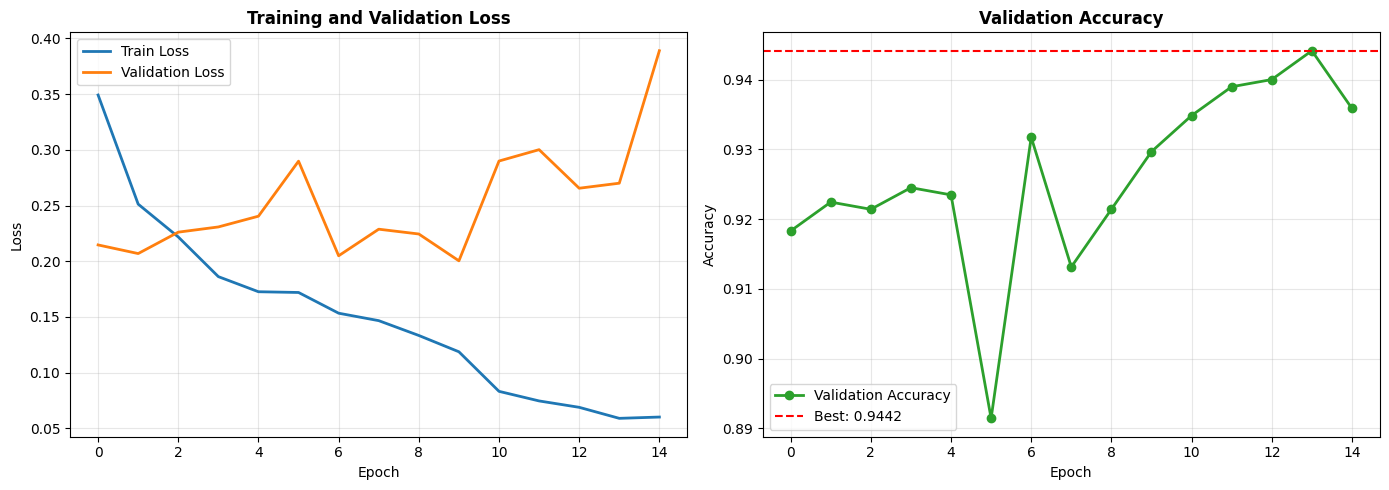

Saved: training_curves.png


In [25]:
# Plot training curves
import matplotlib.pyplot as plt  # Ensure matplotlib is imported
import os
import torch  # Import torch for loading checkpoint

# Load training history if variables don't exist (in case kernel was restarted)
if 'train_losses' not in globals() or 'val_losses' not in globals() or 'val_accuracies' not in globals() or 'best_val_acc' not in globals():
    checkpoint_path = 'best_vangogh_classifier.pth'
    if os.path.exists(checkpoint_path):
        print(f"Loading training history from {checkpoint_path}...")
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
        train_losses = checkpoint.get('train_losses', [])
        val_losses = checkpoint.get('val_losses', [])
        val_accuracies = checkpoint.get('val_accuracies', [])
        best_val_acc = checkpoint.get('best_val_acc', 0.0)
        print(f"Loaded training history: {len(train_losses)} epochs, Best Val Acc: {best_val_acc:.4f}")
    else:
        raise NameError(
            f"Training variables not found and checkpoint file '{checkpoint_path}' doesn't exist!\n"
            "   Please run Step 7 (Train Final Model) first before plotting."
        )

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(train_losses, label='Train Loss', color='#1f77b4', linewidth=2)
axes[0].plot(val_losses, label='Validation Loss', color='#ff7f0e', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(val_accuracies, label='Validation Accuracy', color='#2ca02c', linewidth=2, marker='o')
axes[1].axhline(y=best_val_acc, color='r', linestyle='--', label=f'Best: {best_val_acc:.4f}')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Validation Accuracy', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150)
plt.show()
print("Saved: training_curves.png")


## 9. Test Set Evaluation


In [26]:
# Evaluate on test set (final performance metric)
import torch
import os

# Load best_params if not available (needed for batch_size)
if 'best_params' not in globals():
    checkpoint_path = 'best_vangogh_classifier.pth'
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
        best_params = checkpoint.get('best_params')
        if best_params:
            print(f"Loaded best_params from checkpoint")
    if 'best_params' not in globals() or best_params is None:
        import pickle
        study_save_path = 'optuna_study_results.pkl'
        if os.path.exists(study_save_path):
            with open(study_save_path, 'rb') as f:
                study_data = pickle.load(f)
            best_params = study_data['best_params']
            print(f"Loaded best_params from study file")
        else:
            raise NameError(
                "Cannot find best_params!\n"
                "   Please run Step 6 (Hyperparameter Tuning) or Step 7 (Train Final Model) first."
            )

# Check if final_model exists (step 7 must be run for evaluation)
if 'final_model' not in globals():
    raise NameError(
        "'final_model' not found!\n"
        "   Please run Step 7 (Train Final Model) first before evaluation.\n"
        "   The model needs to be created and trained in step 7."
    )

test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'], shuffle=False, num_workers=2)

final_model.eval()
all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating"):
        images, labels = images.to(device), labels.to(device)
        outputs = final_model(images)
        probs = torch.softmax(outputs, dim=1)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs[:, 1].cpu().numpy())

all_preds, all_labels, all_probs = np.array(all_preds), np.array(all_labels), np.array(all_probs)

# Calculate metrics
test_accuracy = accuracy_score(all_labels, all_preds)
test_precision = precision_score(all_labels, all_preds)
test_recall = recall_score(all_labels, all_preds)
test_f1 = f1_score(all_labels, all_preds)
test_auc = roc_auc_score(all_labels, all_probs)

print("="*60)
print("TEST SET RESULTS")
print("="*60)
print(f"\nMetrics:")
print(f"   Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"   Precision: {test_precision:.4f}")
print(f"   Recall:    {test_recall:.4f}")
print(f"   F1-Score:  {test_f1:.4f}")
print(f"   AUC-ROC:   {test_auc:.4f}")

print(f"\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=['Not Van Gogh', 'Van Gogh']))


Evaluating: 100%|██████████| 16/16 [00:24<00:00,  1.55s/it]

TEST SET RESULTS

Metrics:
   Accuracy:  0.9308 (93.08%)
   Precision: 0.8000
   Recall:    0.7417
   F1-Score:  0.7698
   AUC-ROC:   0.9572

Classification Report:
              precision    recall  f1-score   support

Not Van Gogh       0.95      0.97      0.96       817
    Van Gogh       0.80      0.74      0.77       151

    accuracy                           0.93       968
   macro avg       0.88      0.85      0.86       968
weighted avg       0.93      0.93      0.93       968



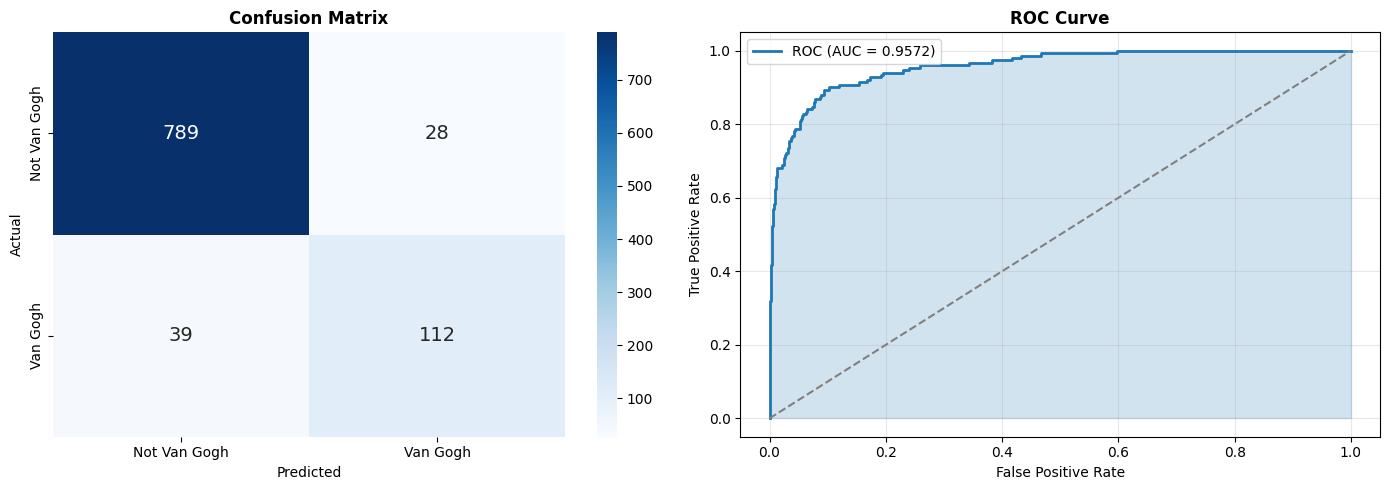

Saved: confusion_matrix_roc.png


In [27]:
# Confusion Matrix and ROC Curve
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Not Van Gogh', 'Van Gogh'],
            yticklabels=['Not Van Gogh', 'Van Gogh'], annot_kws={'size': 14})
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix', fontweight='bold')

fpr, tpr, _ = roc_curve(all_labels, all_probs)
axes[1].plot(fpr, tpr, color='#1f77b4', linewidth=2, label=f'ROC (AUC = {test_auc:.4f})')
axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--')
axes[1].fill_between(fpr, tpr, alpha=0.2, color='#1f77b4')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('confusion_matrix_roc.png', dpi=150)
plt.show()
print("Saved: confusion_matrix_roc.png")


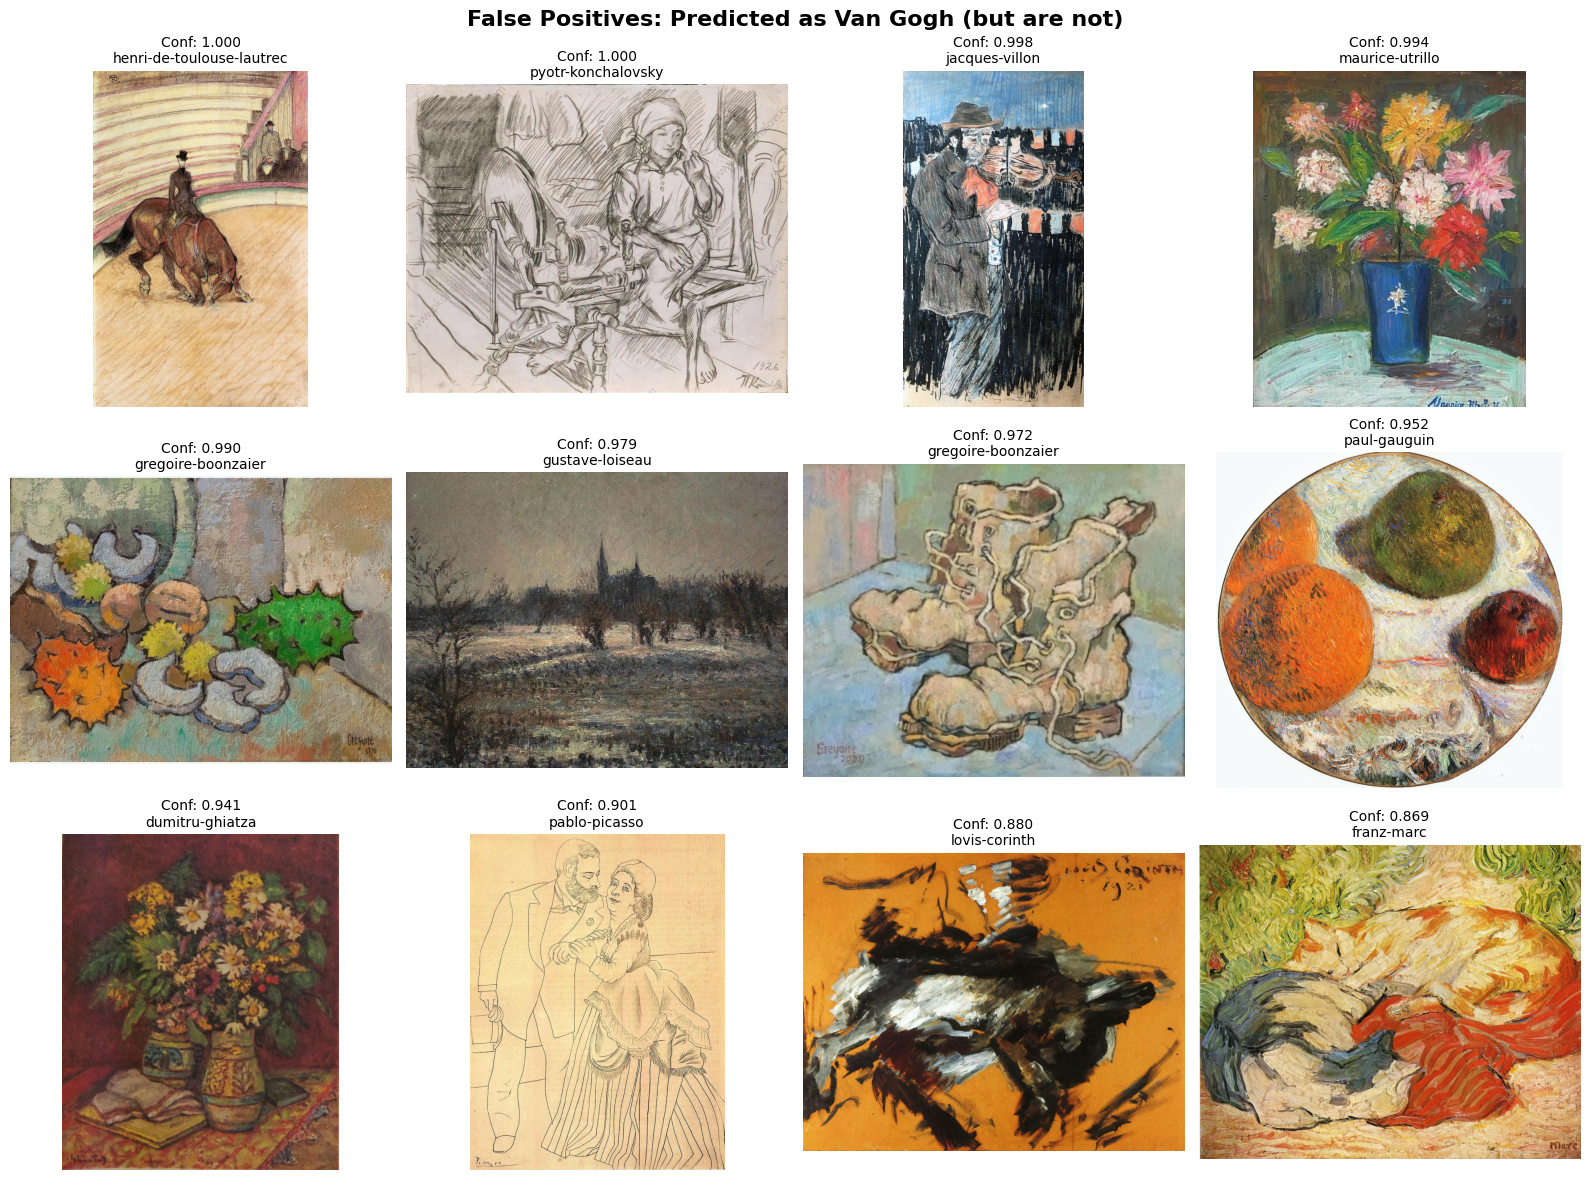

Saved: false_positives.png

Total False Positives: 28 / 968


In [28]:
# Visualize False Positives (images predicted as Van Gogh but are not)
# This is important for analysis in Part 3
import matplotlib.pyplot as plt
from PIL import Image

# Find False Positives
false_positives = []
for idx, (pred, label, prob) in enumerate(zip(all_preds, all_labels, all_probs)):
    if pred == 1 and label == 0:  # Predicted Van Gogh but is not
        false_positives.append((idx, prob))

# Sort by confidence (highest probability first)
false_positives.sort(key=lambda x: x[1], reverse=True)

# Display top False Positives
num_to_show = min(12, len(false_positives))
if num_to_show > 0:
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    fig.suptitle('False Positives: Predicted as Van Gogh (but are not)', fontsize=16, fontweight='bold')
    
    for i, (idx, prob) in enumerate(false_positives[:num_to_show]):
        row = i // 4
        col = i % 4
        
        # Get image path from test dataset
        image_path = test_df.iloc[idx]['filepath']
        image = Image.open(image_path)
        
        axes[row, col].imshow(image)
        axes[row, col].set_title(f'Conf: {prob:.3f}\n{test_df.iloc[idx]["artist"]}', fontsize=10)
        axes[row, col].axis('off')
    
    # Hide empty subplots
    for i in range(num_to_show, 12):
        row = i // 4
        col = i % 4
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.savefig('false_positives.png', dpi=150)
    plt.show()
    print(f"Saved: false_positives.png")
    print(f"\nTotal False Positives: {len(false_positives)} / {len(all_preds)}")
else:
    print("No False Positives found!")


## 10. Final Summary


In [29]:
# Final Summary
print("="*60)
print("PART A - VAN GOGH CLASSIFIER - SUMMARY")
print("="*60)

print("\nDataset:")
print(f"   Total: {len(df)} | Van Gogh: {df['is_van_gogh'].sum()} | Other: {len(df)-df['is_van_gogh'].sum()}")
print(f"   Split: 70% train / 15% val / 15% test")

print("\nBest Hyperparameters:")
for k, v in best_params.items():
    print(f"   {k}: {v}")

print("\nPerformance:")
print(f"   Best Val Acc:  {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"   Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"   Test F1-Score: {test_f1:.4f}")
print(f"   Test AUC-ROC:  {test_auc:.4f}")

print("\nSaved Files:")
print("   best_vangogh_classifier.pth")
print("   training_curves.png")
print("   confusion_matrix_roc.png")

print("\nPart A Complete!")
print("="*60)


PART A - VAN GOGH CLASSIFIER - SUMMARY

Dataset:
   Total: 6450 | Van Gogh: 1005 | Other: 5445
   Split: 70% train / 15% val / 15% test

Best Hyperparameters:
   model_name: VGG19
   lr: 0.00010444892446806132
   optimizer: AdamW
   batch_size: 64
   weight_decay: 0.0007309627378934512
   freeze_features: True
   dropout: 0.19109231969990428

Performance:
   Best Val Acc:  0.9442 (94.42%)
   Test Accuracy: 0.9308 (93.08%)
   Test F1-Score: 0.7698
   Test AUC-ROC:  0.9572

Saved Files:
   best_vangogh_classifier.pth
   training_curves.png
   confusion_matrix_roc.png

Part A Complete!
